In [3]:
# Dependencies
import pandas as pd
import numpy as np

import regex as re
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

# 0. Explore game datasets

In [4]:
# Read in dataset
df_team_data = pd.read_csv('Resources/team_data_query1.csv')

# Drop NA's where there is insufficient data
df_team_data.dropna(subset=['largest_lead_home'], inplace=True)
df_team_data

,#,season_id,game_id,game_date,team_id_home,team_name_home,ftm_home,fta_home,ft_pct_home,oreb_home,...,pts_ot1_away,pts_ot2_away,pts_ot3_away,pts_ot4_away,pts_ot5_away,pts_ot6_away,pts_ot7_away,pts_ot8_away,pts_ot9_away,pts_ot10_away
0,1,21999,29900423,2000-01-02 00:00:00,1610612748,Miami Heat,27,32,0.844,12,...,15.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,21999,29900426,2000-01-03 00:00:00,1610612764,Washington Wizards,14,18,0.778,15,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,21999,29900429,2000-01-03 00:00:00,1610612762,Utah Jazz,16,20,0.800,12,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,21999,29900428,2000-01-03 00:00:00,1610612741,Chicago Bulls,9,17,0.529,16,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,6,21999,29900425,2000-01-03 00:00:00,1610612755,Philadelphia 76ers,28,41,0.683,11,...,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,30484,32022,32200001,2023-02-19 00:00:00,1610616834,Team LeBron,0,0,NaN,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30484,30485,32022,32200001,2023-02-19 00:00:00,1610616834,Team LeBron,0,0,NaN,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30485,30486,32022,32200001,2023-02-19 00:00:00,1610616834,Team LeBron,0,0,NaN,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30486,30487,32022,32200001,2023-02-19 00:00:00,1610616834,Team LeBron,0,0,NaN,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 1. Calculate Team Offensive Rating / Efficiency Rating / Defensive Rating

Using some feature engineering, we can extract features to calculate team efficiency rating of both home and away teams per game. I propose the following formulas to calculate these metrics:

### Offensive Rating
`(ft_pct_ * (oreb_ + ast_)/ total_points) * (largest_lead_ / (1 + times_tied + lead_changes))`

Offensive rating calculation would be the most straightforward: taking free throw percentage, multiplied by the total offensive rebounds and assists, normalized to total points. This function would take into account the proportion of assists, free throws and rebounds, and factors the score gap, ties and lead changes. This will return a percentage 

### Defensive Rating
`opponents_score / (stl_ + blk_ + reb_) / (1 + times_tied + lead_changes))`

Defensive rating takes into account steals, blocks, and rebounds. Measuring steals attempted, blocks attempted and attempted rebounds are difficult to record. When considering factors that contribute to the overall defensive score, I used the opponents score normalized to defensive stats, per times tied or lead changes.

### Efficiency Rating
`avg_total_points_with_ot/((tov_ + pf_) * (1 + (total_ot_points / total_points))`

avg_total_points is the sum of all the points divided by the number of quarters including overtime, rewarding consistent scoring through the game. This is penalized by turnover and personal fouls, generally detrimental to the total score. Finally, multiplied by the total score in overtime to include additional scoring opportunities in overtime.

In [5]:
# define functions for calculations

# Calculate offensive rating:
def calc_offensive_rating(df):
    '''
    :param df: a dataframe of NBA games, requires columns ft_pct, oreb_, pts_, largest_lead_
    :return: None; this script directly modifies the dataframe
    '''
    teams = ['home', 'away']
    for team in teams:
        freethrow_pct_var = df[f"ft_pct_{team}"]
        offensive_reb_var = df[f"oreb_{team}"]
        assists_var = df[f"pts_{team}"]
        total_points_var = df[f"pts_{team}"]
        largest_lead_var = df[f"largest_lead_{team}"]
        df[f'offensive_rating_{team}'] = np.cbrt((freethrow_pct_var * ((offensive_reb_var + assists_var)/total_points_var)) / (1 + df['times_tied'] + df['lead_changes']))

# Calculate defensive rating:
def calc_defensive_rating(df):
    '''
    :param df: a dataframe of historic NBA games, requiring columns (opponents_score), stl_, blk_, reb_, times_tied, lead_changes
    :return: None, function directly modifies the dataframe
    '''
    teams = ['home', 'away']
    for i in range(len(teams)):
        opponent_score_var= df[f'pts_{teams[i-1]}']
        steals_var = df[f"stl_{teams[i]}"]
        blocks_var = df[f"blk_{teams[i]}"]
        rebounds_var = df[f"reb_{teams[i]}"]
        df[f"defensive_rating_{teams[i]}"] = np.cbrt((opponent_score_var / (steals_var + blocks_var + rebounds_var)) /  (1 + df['times_tied'] + df['lead_changes']))

def calc_efficiency_rating(df):
    '''
    :param df: a dataframe of historic NBA games data, requiring columns with OT, points with OT
    :return: None: function directly modifies the dataframe
    '''
    teams = ['home', 'away']
    for team in teams:
        ot_quarters_df = df.filter(regex=f"pts_ot[0-9][0-9]?_{team}")
        nonna_count = 10 - ot_quarters_df.isna().sum(axis=1)
        ot_pts_sum = ot_quarters_df.sum(axis=1)
        df[f"efficiency_rating_{team}"] = np.log((df[f'pts_{team}']/(df[f'tov_{team}'] / df[f'pf_{team}'])) * (1 + (ot_pts_sum / df[f'pts_{team}'])))

In [6]:
# Perform calculations
calc_offensive_rating(df_team_data)
calc_defensive_rating(df_team_data)
calc_efficiency_rating(df_team_data)
# Preview new dataframe
df_team_data

,#,season_id,game_id,game_date,team_id_home,team_name_home,ftm_home,fta_home,ft_pct_home,oreb_home,...,pts_ot7_away,pts_ot8_away,pts_ot9_away,pts_ot10_away,offensive_rating_home,offensive_rating_away,defensive_rating_home,defensive_rating_away,efficiency_rating_home,efficiency_rating_away
0,1,21999,29900423,2000-01-02 00:00:00,1610612748,Miami Heat,27,32,0.844,12,...,NaN,NaN,NaN,NaN,0.439721,0.458726,0.524216,0.514714,5.463832,5.191898
2,3,21999,29900426,2000-01-03 00:00:00,1610612764,Washington Wizards,14,18,0.778,15,...,NaN,NaN,NaN,NaN,0.367840,0.342740,0.450115,0.485706,4.882802,4.648230
3,4,21999,29900429,2000-01-03 00:00:00,1610612762,Utah Jazz,16,20,0.800,12,...,NaN,NaN,NaN,NaN,0.666463,0.593624,0.819015,0.905114,5.573737,4.689307
4,5,21999,29900428,2000-01-03 00:00:00,1610612741,Chicago Bulls,9,17,0.529,16,...,NaN,NaN,NaN,NaN,0.872129,0.920074,1.155764,0.974864,3.844642,4.432885
5,6,21999,29900425,2000-01-03 00:00:00,1610612755,Philadelphia 76ers,28,41,0.683,11,...,NaN,NaN,NaN,NaN,0.314080,0.343396,0.455231,0.457375,5.685279,5.329089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,30484,32022,32200001,2023-02-19 00:00:00,1610616834,Team LeBron,0,0,NaN,13,...,0.0,0.0,0.0,0.0,NaN,0.272684,0.443731,0.433714,4.471639,3.423176
30484,30485,32022,32200001,2023-02-19 00:00:00,1610616834,Team LeBron,0,0,NaN,13,...,0.0,0.0,0.0,0.0,NaN,0.272684,0.443731,0.433714,4.471639,3.423176
30485,30486,32022,32200001,2023-02-19 00:00:00,1610616834,Team LeBron,0,0,NaN,13,...,0.0,0.0,0.0,0.0,NaN,0.272684,0.443731,0.433714,4.471639,3.423176
30486,30487,32022,32200001,2023-02-19 00:00:00,1610616834,Team LeBron,0,0,NaN,13,...,0.0,0.0,0.0,0.0,NaN,0.272684,0.443731,0.433714,4.471639,3.423176


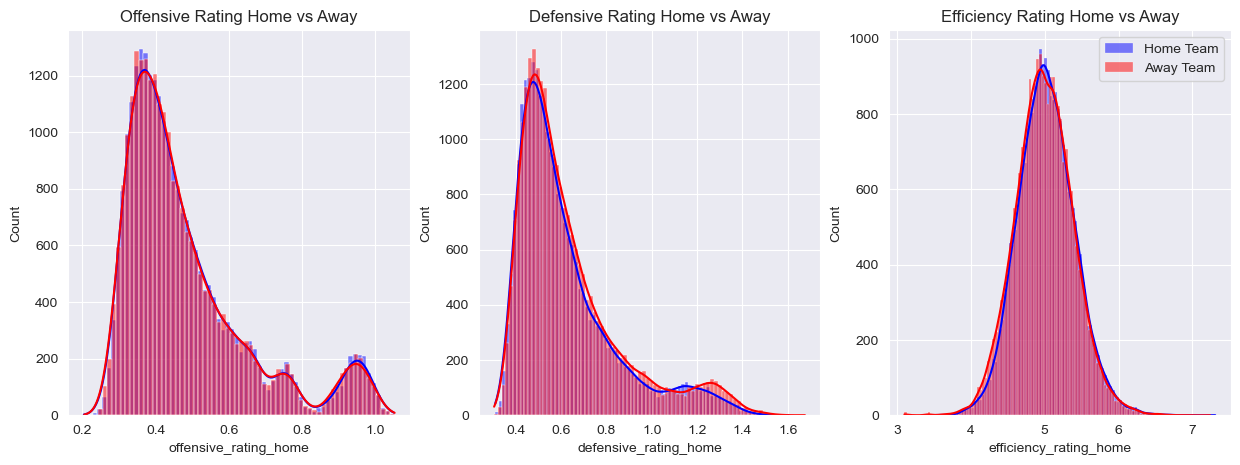

In [7]:
# Visualize distribution of Offensive Performance
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.histplot(data=df_team_data['offensive_rating_home'], color='Blue', label='Home Team', ax=ax[0], alpha=0.5, kde=True)
sns.histplot(data=df_team_data['offensive_rating_away'], color='Red', label='Away Team', ax=ax[0], alpha=0.5, kde=True)
ax[0].set_title('Offensive Rating Home vs Away')
sns.histplot(data=df_team_data['defensive_rating_home'], color='Blue', label='Home Team', ax=ax[1], alpha=0.5, kde=True)
sns.histplot(data=df_team_data['defensive_rating_away'], color='Red', label='Away Team', ax=ax[1], alpha=0.5, kde=True)
ax[1].set_title('Defensive Rating Home vs Away')
sns.histplot(data=df_team_data['efficiency_rating_home'], color='Blue', label='Home Team', ax=ax[2], alpha=0.5, kde=True)
sns.histplot(data=df_team_data['efficiency_rating_away'], color='Red', label='Away Team', ax=ax[2], alpha=0.5, kde=True)
ax[2].set_title('Efficiency Rating Home vs Away')
plt.legend()
plt.show()

In [8]:
# Save table
df_team_data.to_csv('Resources/team_data_scored.csv', index_label="#")